In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Conv2D,Conv2DTranspose,Flatten,Lambda, Input, Dense,Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
from keras.layers.merge import concatenate
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
def sampling(args):
    z_mean,var_log = args
    batch=K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    epsilon=K.random_normal(shape=(batch,dim))
    return z_mean+K.exp(0.5*var_log)*epsilon

In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

imag_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, imag_size,imag_size,1])
x_test = np.reshape(x_test, [-1,  imag_size,imag_size,1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

num_labels=len(np.unique(y_train))
print(num_labels)
label_shape=(num_labels,)

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

# network parameters
batch_size = 128
dim_latent = 20
epochs = 50



10


In [4]:
def build_encoder(inputs):
    #inputs=Input(shape=(imag_size,imag_size,1),name='encoder_input')
    z_mean,z_log_var,z,shape0=get_z_sample(inputs)
    encoder=Model(inputs,[z_mean,z_log_var,z],name='encoder')
    encoder.summary()
    return encoder,shape0

In [5]:
#encoder,shape0=build_encoder()

In [6]:
def build_decoder(inputs,shape0):
    #inputs=Input(shape=(dim_latent,),name='latent_input')
    x=Dense(shape0[1] * shape0[2] * shape0[3], activation='relu')(inputs)
    x=Reshape((shape0[1],shape0[2],shape0[3]))(x)
    x=Conv2DTranspose(filters=nfilters_layer[0],kernel_size=3,strides=2,padding='same',activation='relu')(x)
    outputs=Conv2DTranspose(filters=1,kernel_size=3,strides=2,padding='same',activation='sigmoid')(x)
    decoder=Model(inputs,outputs,name='decoder')
    decoder.summary()
    return decoder

In [7]:
def build_vae_cnn():
    inputs=Input(shape=(imag_size,imag_size,1),name='encoder_input')
    nfilters_layer=[32,64]
    labels=Input(shape=label_shape,name='labels')
    x=Dense(imag_size*imag_size)(labels)
    x=Reshape((imag_size,imag_size,1))(x)
    x=concatenate([inputs,x])
    print('x.shape is: '+str(x.shape))
    x=Conv2D(filters=nfilters_layer[0],kernel_size=3,strides=2,padding='same',activation='relu')(x)
    x=Conv2D(filters=nfilters_layer[1],kernel_size=3,strides=2,padding='same',activation='relu')(x)   
    shape0 = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(int(1.5*dim_latent), activation='relu')(x)
 
    z_mean=Dense(dim_latent,name='z_mean')(x)
    z_log_var=Dense(dim_latent,name='z_log_var')(x)
    z=Lambda(sampling,output_shape=(dim_latent,),name='layer_z')([z_mean,z_log_var])
    encoder = Model([inputs,labels], [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    #plot_model(encoder,to_file='vae_encoder_model_cond.png',show_shapes=True)
    
    latent_inputs = Input(shape=(dim_latent,), name='z_sampling')
    x=concatenate([latent_inputs,labels])
    print(x.shape)
    x = Dense(int(1.5*dim_latent), activation='relu')(x)
    x = Dense(shape0[1]*shape0[2]*shape0[3], activation='relu')(x)
    x = Reshape((shape0[1], shape0[2], shape0[3]))(x)
    x=Conv2DTranspose(filters=nfilters_layer[0],kernel_size=3,strides=2,padding='same',activation='relu')(x)
    outputs = Conv2DTranspose(filters=1,kernel_size=3,strides=2, activation='sigmoid',padding='same',name='decoder_output')(x)

    # instantiate decoder model
    decoder = Model([latent_inputs,labels], outputs, name='decoder')
    decoder.summary()
    #plot_model(decoder,to_file='vae_decoder_model_cond.png',show_shapes=True)
    
    outputs = decoder([encoder([inputs,labels])[2],labels])
    vae = Model([inputs,labels], outputs, name='vae_model_cond')
    #plot_model(vae,to_file='vae_model_cond.png',show_shapes=True)

    def vae_loss(inputs,outputs):
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
        reconstruction_loss*= imag_size * imag_size
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        loss = K.mean(reconstruction_loss + kl_loss)
        return loss
    
    vae.compile(optimizer='adam',loss=vae_loss)
    return vae

In [8]:
vae=build_vae_cnn()
vae.summary()

x.shape is: (?, 28, 28, 2)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
labels (InputLayer)             (None, 10)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          8624        labels[0][0]                     
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_1[0][0]                    
_________

In [12]:
vae.fit([x_train,y_train],x_train,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=([x_test, y_test], x_test) )    

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 34s 570us/step - loss: 198.9426 - val_loss: 152.1080
Epoch 2/50
60000/60000 [==============================] - 31s 525us/step - loss: 136.2110 - val_loss: 125.3771
Epoch 3/50
60000/60000 [==============================] - 32s 535us/step - loss: 120.9033 - val_loss: 115.4177
Epoch 4/50
60000/60000 [==============================] - 52s 866us/step - loss: 113.6552 - val_loss: 110.4215
Epoch 5/50
60000/60000 [==============================] - 60s 1ms/step - loss: 109.4251 - val_loss: 107.7946
Epoch 6/50
60000/60000 [==============================] - 61s 1ms/step - loss: 106.8573 - val_loss: 105.0328
Epoch 7/50
60000/60000 [==============================] - 63s 1ms/step - loss: 105.1565 - val_loss: 103.9640
Epoch 8/50
60000/60000 [==============================] - 60s 1ms/step - loss: 104.0359 - val_loss: 102.6565
Epoch 9/50
60000/60000 [==============================] - 60s 1ms/step

In [13]:
vae.save_weights('vae_model_cond_z20.h5')

In [14]:
def plot_figure(models,data,batch_size=32,model_name='vae_mnist'):
    encoder,decoder=models
    x_test,y_test=data
    os.makedirs(model_name,exist_ok=True)
    filename=os.path.join(model_name,'vae_mean.png')
    z_mean,_,_=encoder.predict([x_test,y_test],batch_size=batch_size)
    plt.figure(figsize=(12,10))
    plt.scatter(z_mean[:,0],z_mean[:,1],c=y_test)
    plt.colorbar()
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.savefig(filename)
    plt.show()
    filename=os.path.join(model_name,"digits_over_latent.png")
    n=20
    digit_size=28
    figure=np.zeros((digit_size*n,digit_size*n))
    grid_x=np.linspace(-4,4,n)
    grid_y=np.linspace(-4,4,n)[:,:,-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [15]:
np.eye(10)[3]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [43]:
nsample=100
step=20
x_test_sample=x_test[range(0,step*nsample,step),:]
test_label=8
y_test_label = np.eye(num_labels)[test_label]
y_test_label=np.tile(y_test_label,(nsample,1))
#print(y_test_label)
print(x_test_sample.shape)
#x_test_sample=x_test_sample.reshape(-1,784)
outputs=vae.predict([x_test_sample,y_test_label],batch_size=batch_size)
#outputs=vae.predict([x_test[range(0,step*nsample,step),:],y_test[range(0,step*nsample,step),:]],batch_size)

(100, 28, 28, 1)


(100, 28, 28)


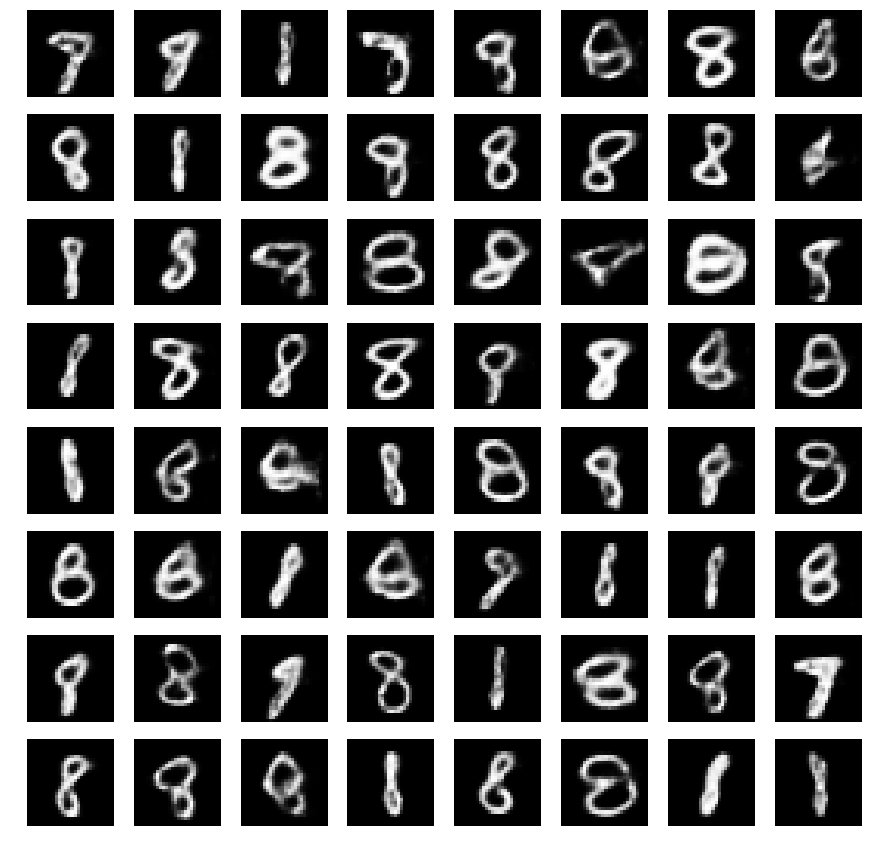

In [44]:
outputs=np.reshape(outputs,[-1,28,28])
print(outputs.shape)

nrow=8
ncol=8
plt.figure(figsize=(15,15))
for i in range(64):
    plt.subplot(nrow,ncol,i+1)
    plt.imshow(outputs[i],cmap='gray')
    plt.axis('off')
